**MNIST ("Modified National Institute of Standards and Technology") is the de facto “hello world” dataset of computer vision. Since its release in 1999, this classic dataset of handwritten images has served as the basis for benchmarking classification algorithms. As new machine learning techniques emerge, MNIST remains a reliable resource for researchers and learners alike.**

**Your goal is to correctly identify digits from a dataset of tens of thousands of handwritten images. **

In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

## Read data from csv. file

Data has been downloaded already!

Original reference: The csv file we are using can be found here: https://www.kaggle.com/c/digit-recognizer/data

In [2]:
# Read in training data from train.csv
dfTrain = pd.read_csv('train.csv')
dfTrainFeatureVectors = dfTrain.drop(['label'], axis=1)
trainFeatureVectors = dfTrainFeatureVectors.values.astype(dtype=np.float32)
trainFeatureVectorsConvoFormat = trainFeatureVectors.reshape(42000, 28, 28, 1)

trainLabelsList = dfTrain['label'].tolist()
ohTrainLabelsTensor = tf.one_hot(trainLabelsList, depth=10)
ohTrainLabelsNdarray = tf.Session().run(ohTrainLabelsTensor).astype(dtype=np.float64)

# Read in testing data from test.csv
dfTest = pd.read_csv('test.csv')
testFeatureVectors = dfTest.values.astype(dtype=np.float32)
testFeatureVectorsConvoFormat = testFeatureVectors.reshape(28000, 28, 28, 1)

In [3]:
len(dfTrain)

42000

In [4]:
dfTrain.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dfTest.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Display image from csv. file

This lets us verify that we have read in and structured the data correctly.

### Training image

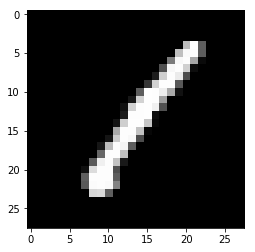

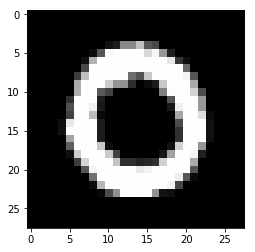

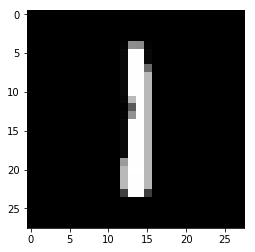

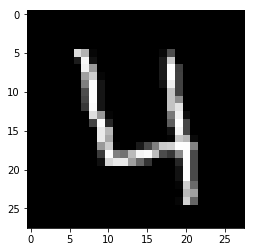

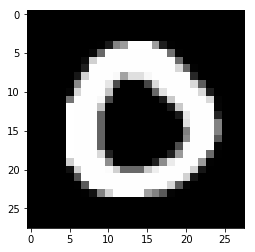

In [8]:
for i in range(0, 5):
# Display an image read in from the CSV
# testFeatureVectorsConvoFormat values are: [2, 0, 9, 0, 3, 7, ...]
    pixels = trainFeatureVectorsConvoFormat[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

### Test image

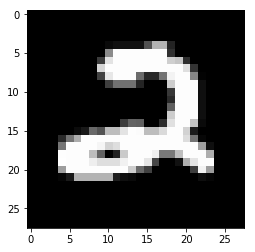

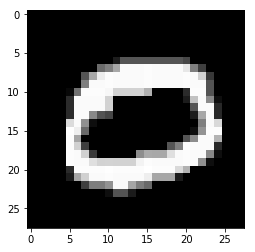

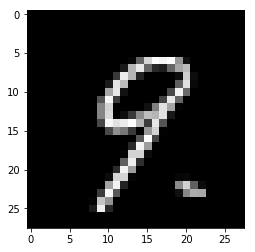

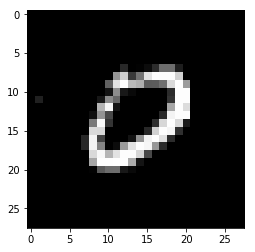

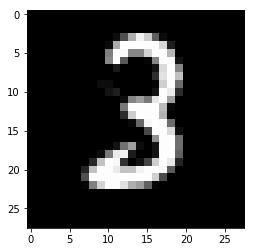

In [9]:
for i in range(0, 5):
# Display an image read in from the CSV
# testFeatureVectorsConvoFormat values are: [2, 0, 9, 0, 3, 7, ...]
    pixels = testFeatureVectorsConvoFormat[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

## Construct TensorFlow graph

In [10]:
# Define Tensorflow graph
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
Y_ = tf.placeholder(tf.float32, [None, 10])
lr = tf.placeholder(tf.float32)
pkeep = tf.placeholder(tf.float32)

K = 6  # first convolutional layer output depth
L = 12  # second convolutional layer output depth
M = 24  # third convolutional layer
N = 200  # fully connected layer (softmax)

W1 = tf.Variable(tf.truncated_normal([6, 6, 1, K], stddev=0.1))  # 6x6 patch, 1 input channel, K output channels
B1 = tf.Variable(tf.constant(0.1, tf.float32, [K]))
W2 = tf.Variable(tf.truncated_normal([5, 5, K, L], stddev=0.1))
B2 = tf.Variable(tf.constant(0.1, tf.float32, [L]))
W3 = tf.Variable(tf.truncated_normal([4, 4, L, M], stddev=0.1))
B3 = tf.Variable(tf.constant(0.1, tf.float32, [M]))

W4 = tf.Variable(tf.truncated_normal([7 * 7 * M, N], stddev=0.1))
B4 = tf.Variable(tf.constant(0.1, tf.float32, [N]))

W5 = tf.Variable(tf.truncated_normal([N, 10], stddev=0.1))
B5 = tf.Variable(tf.constant(0.1, tf.float32, [10]))

# The model
stride = 1  # output is 28x28
Y1 = tf.nn.relu(tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME') + B1)
stride = 2  # output is 14x14
Y2 = tf.nn.relu(tf.nn.conv2d(Y1, W2, strides=[1, stride, stride, 1], padding='SAME') + B2)
stride = 2  # output is 7x7
Y3 = tf.nn.relu(tf.nn.conv2d(Y2, W3, strides=[1, stride, stride, 1], padding='SAME') + B3)

# reshape the output from the third convolution for the fully connected layer
YY = tf.reshape(Y3, shape=[-1, 7 * 7 * M])

Y4 = tf.nn.relu(tf.matmul(YY, W4) + B4)
YY4 = tf.nn.dropout(Y4, pkeep)
Ylogits = tf.matmul(YY4, W5) + B5
Y = tf.nn.softmax(Ylogits)

## Define calculations we need from the Neural Network

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

# accuracy of the trained model, between 0 (worst) and 1 (best)
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(Y, 1)

# training step, the learning rate is a placeholder
train_step = tf.train.AdamOptimizer(lr).minimize(cross_entropy)

## Train the Neural Network <font color = red>(Warning: this process roughly takes 30 minutes!)

In [12]:
print('How many iterations will scan through the entire train image set?')
# 5000*100/32000

How many iterations will scan through the entire train image set?


In [13]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

def getBatch(i, size, trainFeatures, trainLabels):
#     startIndex = (i * size) % 42000
    startIndex = (i * size) % 32000 # training set: 32,000   validation set: 10,000 images
    endIndex = startIndex + size
    batch_X = trainFeatures[startIndex : endIndex]
    batch_Y = trainLabels[startIndex : endIndex]
    return batch_X, batch_Y

# You can call this function in a loop to train the model, 100 images at a time
def training_step(i):

    # training on batches of 100 images with 100 labels
    size = 100
    batch_X, batch_Y = getBatch(i, size, trainFeatureVectorsConvoFormat, ohTrainLabelsNdarray)

    # learning rate decay
    max_learning_rate = 0.003
    min_learning_rate = 0.0001
    decay_speed = 2000.0
    learning_rate = min_learning_rate + (max_learning_rate - min_learning_rate) * math.exp(-i/decay_speed)

    # compute training values
    if i % 100 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on batch_X and batch_Y (ie. on 100 pieces of data)
        '''
        a, c = sess.run([accuracy, cross_entropy], {X: batch_X, Y_: batch_Y, pkeep: 1.0})
        print(str(i) + ": training accuracy: " + str(a) + " training loss: " + str(c) + " (lr:" + str(learning_rate) + ")")

    # compute test values
    if i % 500 == 0:
        '''
        When we sess.run here, we are calculating the accuracy and cross_entropy of the model on validation data (last 10,000 train images)
        '''
        a, c = sess.run([accuracy, cross_entropy], {X: trainFeatureVectorsConvoFormat[-10000:], Y_: ohTrainLabelsNdarray[-10000:], pkeep: 1.0})
        print(str(i) + ": ********* validation accuracy: " + str(a) + " test loss: " + str(c))

    # the backpropagation training step
    sess.run(train_step, {X: batch_X, Y_: batch_Y, lr: learning_rate, pkeep: 0.75})

# Run number of iterations training the NN    
for i in range(10000+1): 
# for i in range(5000+1): 
    training_step(i)

0: training accuracy: 0.08 training loss: 10016.8 (lr:0.003)
0: ********* validation accuracy: 0.0741 test loss: 10146.0
100: training accuracy: 0.93 training loss: 31.3368 (lr:0.0028585653310520707)
200: training accuracy: 0.94 training loss: 24.7336 (lr:0.0027240285123042826)
300: training accuracy: 0.95 training loss: 19.0238 (lr:0.0025960531316326675)
400: training accuracy: 0.96 training loss: 16.7652 (lr:0.0024743191839261473)
500: training accuracy: 0.99 training loss: 6.09752 (lr:0.002358522270907074)
500: ********* validation accuracy: 0.9572 test loss: 13.3868
600: training accuracy: 0.95 training loss: 20.4465 (lr:0.002248372839976982)
700: training accuracy: 0.98 training loss: 3.77514 (lr:0.002143595460184269)
800: training accuracy: 0.99 training loss: 3.35053 (lr:0.002043928133503354)
900: training accuracy: 0.98 training loss: 5.57409 (lr:0.001949121639703143)
1000: training accuracy: 0.98 training loss: 4.06111 (lr:0.0018589389131666372)
1000: ********* validation accu

8800: training accuracy: 1.0 training loss: 0.00301284 (lr:0.00013560428571889846)
8900: training accuracy: 1.0 training loss: 0.00124887 (lr:0.0001338678442141468)
9000: training accuracy: 1.0 training loss: 0.00300986 (lr:0.0001322160899609027)
9000: ********* validation accuracy: 0.9825 test loss: 10.7307
9100: training accuracy: 1.0 training loss: 0.000436407 (lr:0.00013064489271317272)
9200: training accuracy: 1.0 training loss: 0.00586373 (lr:0.0001291503236594374)
9300: training accuracy: 1.0 training loss: 0.00749942 (lr:0.00012772864559857617)
9400: training accuracy: 1.0 training loss: 0.00521058 (lr:0.00012637630359491788)
9500: training accuracy: 1.0 training loss: 0.000861546 (lr:0.00012508991608904985)
9500: ********* validation accuracy: 0.9828 test loss: 10.5061
9600: training accuracy: 1.0 training loss: 0.0116616 (lr:0.0001238662664421581)
9700: training accuracy: 1.0 training loss: 0.00220928 (lr:0.00012270229489275475)
9800: training accuracy: 1.0 training loss: 0.0

## Make Predictions

In [14]:
# Print the accuracy on all 42,000 traing data
# a, c = sess.run([accuracy, cross_entropy], {X: trainFeatureVectorsConvoFormat, Y_: ohTrainLabelsNdarray, pkeep: 1.0})
# print("\n ********* average accuracy: " + str(a) + " average loss: " + str(c))

In [15]:
# Get predictions on test data, first 10 images only
p = sess.run([predictions], {X: testFeatureVectorsConvoFormat[0:10], pkeep: 1.0})

# Get predictions on test data, 28,000 images, may cause memory shortage !
# p = sess.run([predictions], {X: testFeatureVectorsConvoFormat, pkeep: 1.0})

In [16]:
p[0]

array([2, 0, 9, 0, 3, 7, 0, 3, 0, 3])

### Test image

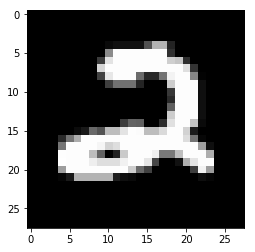

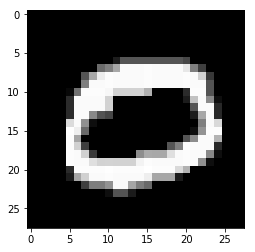

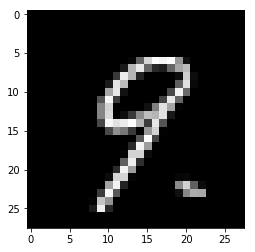

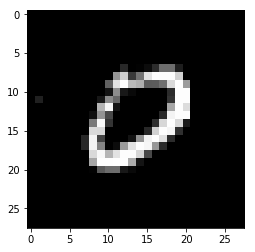

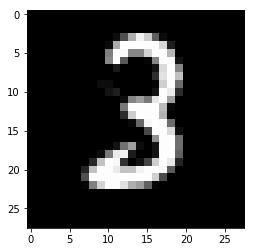

In [17]:
for i in range(0, 5):
# Display an image read in from the CSV
# testFeatureVectorsConvoFormat values are: [2, 0, 9, 0, 3, 7, ...]
    pixels = testFeatureVectorsConvoFormat[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

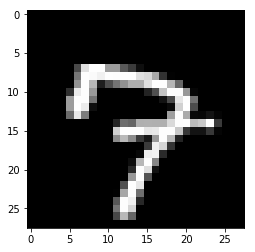

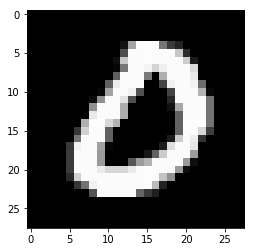

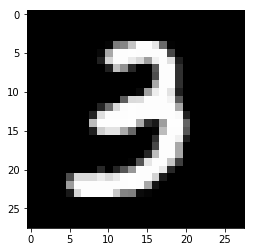

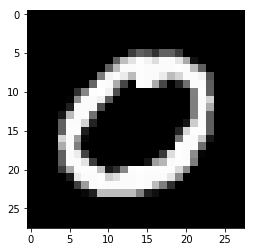

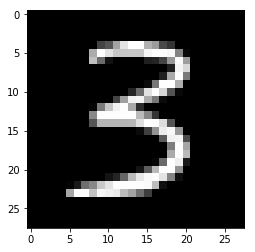

In [19]:
for i in range(5, 10):
# Display an image read in from the CSV
# testFeatureVectorsConvoFormat values are: [2, 0, 9, 0, 3, 7, ...]
    pixels = testFeatureVectorsConvoFormat[i].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.show()

---

In [ ]:
# Write predictions to csv file
# results = pd.DataFrame({'ImageId': pd.Series(range(1, len(p[0]) + 1)), 'Label': pd.Series(p[0])})
# results.to_csv('results.csv', index=False)
# results

---